In [99]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from util.StringObjectParser import StringObjectParser

In [100]:
sns.set_theme(style="whitegrid")

# Load Data

## Subsetting Performance

In [101]:
current_directory = os.getcwd()
print(f"The current working directory is: {current_directory}")

xlsx_files = [file for file in os.listdir(current_directory) if file.endswith('.xlsx')]
dataframes = []
for xf in xlsx_files:
    df = pd.read_excel(os.path.join(current_directory, xf))
    df["subsetting_method"] = xf.split("-")[1]
    df["benchmark"] = xf.split("-")[2]
    df["comments"] = xf.split("-")[4].replace(".xlsx", "")
    dataframes.append(df)
performance_df = pd.concat(dataframes, ignore_index=True)


The current working directory is: /data/kluoma/skalpel-subsetting-evaluation/subsetting_results


## Subsetting Diagnosis

Subsetting diagnosis contains the results of the subseeting_diagnosis.py script. 

Columns:
- **database** (str): benchmark database associated with question
- **question_number** (int): benchmark database NL-SQL question number
- **gold_query_tables** (set): minimum tables required for a correct query
- **missing_tables** (set): gold_query_tables - tables in predicted subset
- **hidden_tables** (set): missing tables that are not semantically similar to any n-grams in the natural language question
- **ambiguous_extra_tables** (dict): a dict of natural language words that are semantically similar to tables in the schema that are not in the gold query. The dict key is the natural language word, and the value is a set of table names.
- **gold_query_columns** (set): minimum columns required for a correct query, formatted as table.column
- **missing_columns** (set): gold_query_columns - columns in predicted subset
- **value_reference_problem_columns** (dict): Missing columns where a word in the natural language question is semantically similar to a value in the required column, but there is no NL word match to the required column.
-- **ambiguous_extra_columns** (dict):  a dict of natural language words that are semantically similar to columns in the schema that are not in the gold query. The dict key is the natural language word, and the value is a set of column names formatted as table.column.

In [102]:
current_directory = f"{os.getcwd()}/diagnosis"
xlsx_files = [file for file in os.listdir(current_directory) if file.endswith('.xlsx')]
dataframes = []
for xf in xlsx_files:
    df = pd.read_excel(os.path.join(current_directory, xf))
    df = df.rename(columns={
        "hidden_relations": "hidden_tables",
        "value_reference_problem_attributes": "value_reference_problem_columns",
        "gold_query_attributes": "gold_query_columns",
        "missing_attributes": "missing_columns"
        })
    df = df.drop(columns=["value_reference_problem_relations"], errors="ignore")
    df["subsetting_method"] = xf.split("-")[2]
    df["benchmark"] = xf.split("-")[3]
    df["comments"] = xf.split("-")[-1].replace(".xlsx", "")
    dataframes.append(df)
diagnosis_df = pd.concat(dataframes, ignore_index=True)

ValueError: No objects to concatenate

# Process Data

## Process Performance Data

In [ ]:
# Simple replacement of "set()" with actual set
performance_df = performance_df.replace("set()", "{None}")

In [ ]:
# Annotate (True, False) if all models were able to handle a specific schema (e.g., it fit inside the context window)
# We can recognize databases where some models failed if the inference time is -1
too_big_schemas = list(performance_df.query("inference_time<0").database.unique())
performance_df["all_models_compatible"] = performance_df.database.apply(lambda x: x not in too_big_schemas)

## Process Diagnosis Data

In [ ]:
diagnosis_df["missing_tables_count"] = diagnosis_df.missing_tables.apply(
    lambda x: len(StringObjectParser.string_to_python_object(x, use_eval=True))
    )
diagnosis_df["hidden_tables_count"] = diagnosis_df.hidden_tables.apply(
    lambda x: len(StringObjectParser.string_to_python_object(x, use_eval=True))
)

/data/kluoma/skalpel-subsetting-evaluation/subsetting_results/util/StringObjectParser.py:51: UserWarning: Using eval can be dangerous. Make sure the input string is from a trusted source.
  warnings.warn("Using eval can be dangerous. Make sure the input string is from a trusted source.")
/data/kluoma/skalpel-subsetting-evaluation/subsetting_results/util/StringObjectParser.py:51: UserWarning: Using eval can be dangerous. Make sure the input string is from a trusted source.
  warnings.warn("Using eval can be dangerous. Make sure the input string is from a trusted source.")


# EDA

### Total Recall, Precision, F1 and Schema Proportions by Subsetting Method (All Databases)

This a first look, and one that isn't very useful. On the surface, it suggests pretty big differences between various subsetting methods. However, what we're not seeing here are the methods that weren't capable of handling very large schemas. So it's possible that those methods are being unfairly rewarded (or punished) compared to those that were able to take on the largest schemas. We'll need to separate out the databases that all methods were capable of handling, and compare only those across methods.

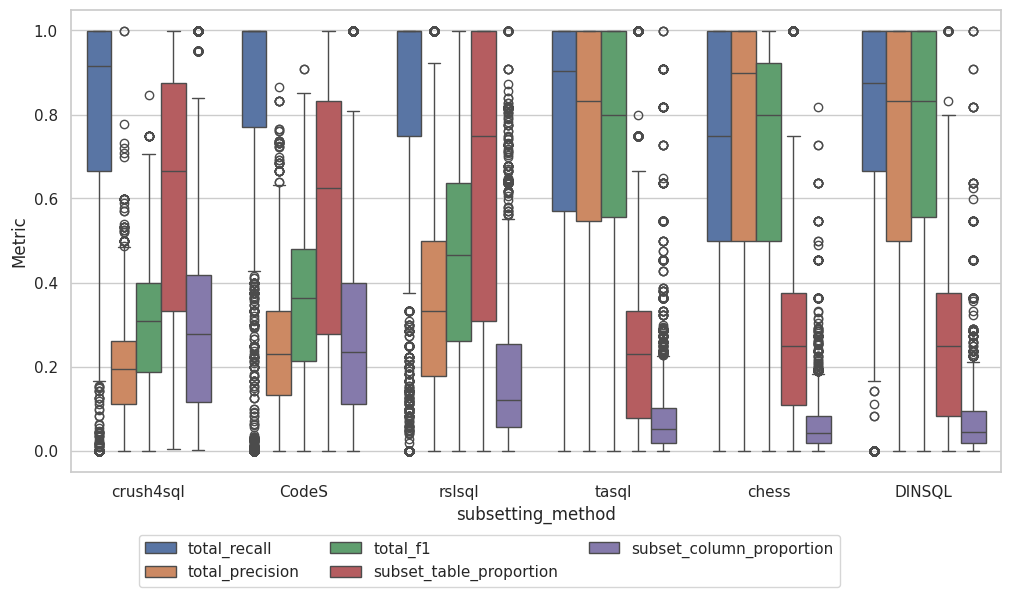

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=performance_df.melt(
        id_vars=["subsetting_method"],
        value_vars=["total_recall", "total_precision", "total_f1", "subset_table_proportion", "subset_column_proportion"],
        value_name="Metric",
        var_name="Metric Name"
    ).query("Metric<=1.0"),
    x="subsetting_method",
    y="Metric",
    hue="Metric Name"
)
plt.legend(bbox_to_anchor=(0.45, -0.25), loc='lower center', borderaxespad=0, ncols=3)

### Total Recall, Precision, F1 and Schema Proportions by Subsetting Method (Only All-Model-Compatible Databases)

This is the same chart as above, except now we filter out the databases where some subsetting methods were unable to handle them due to schema size 

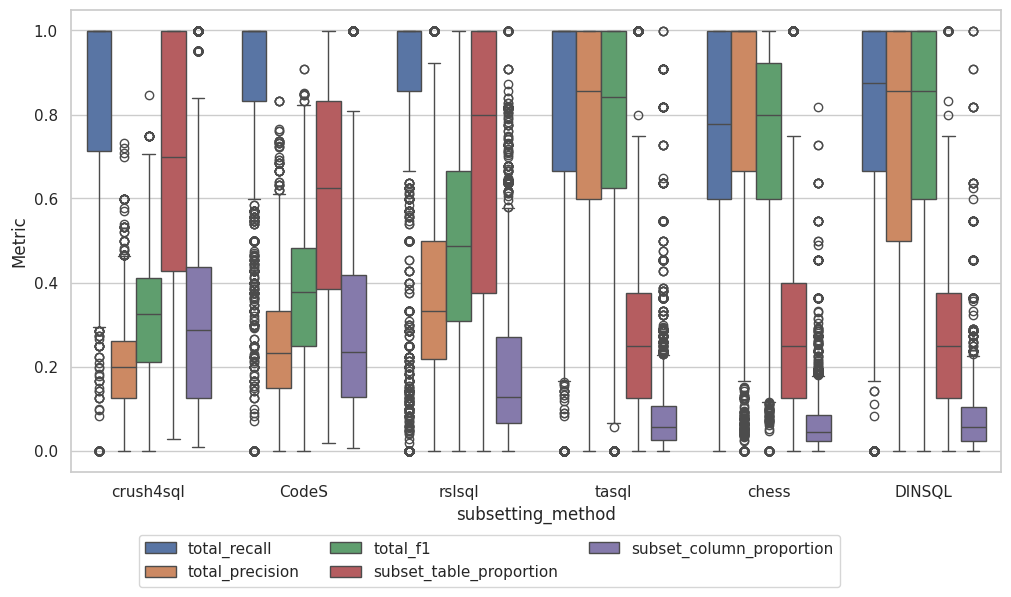

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=performance_df.melt(
        id_vars=["subsetting_method", "all_models_compatible"],
        value_vars=["total_recall", "total_precision", "total_f1", "subset_table_proportion", "subset_column_proportion"],
        value_name="Metric",
        var_name="Metric Name"
    ).query("Metric<=1.0 and all_models_compatible"),
    x="subsetting_method",
    y="Metric",
    hue="Metric Name"
)
plt.legend(bbox_to_anchor=(0.45, -0.25), loc='lower center', borderaxespad=0, ncols=3)

### Total Recall, Precision, F1 and Schema Proportions by Subsetting Method (Only Very Large Database Schemas)

This is the same chart as above, except now we only compare the databases that were too large for at least one model

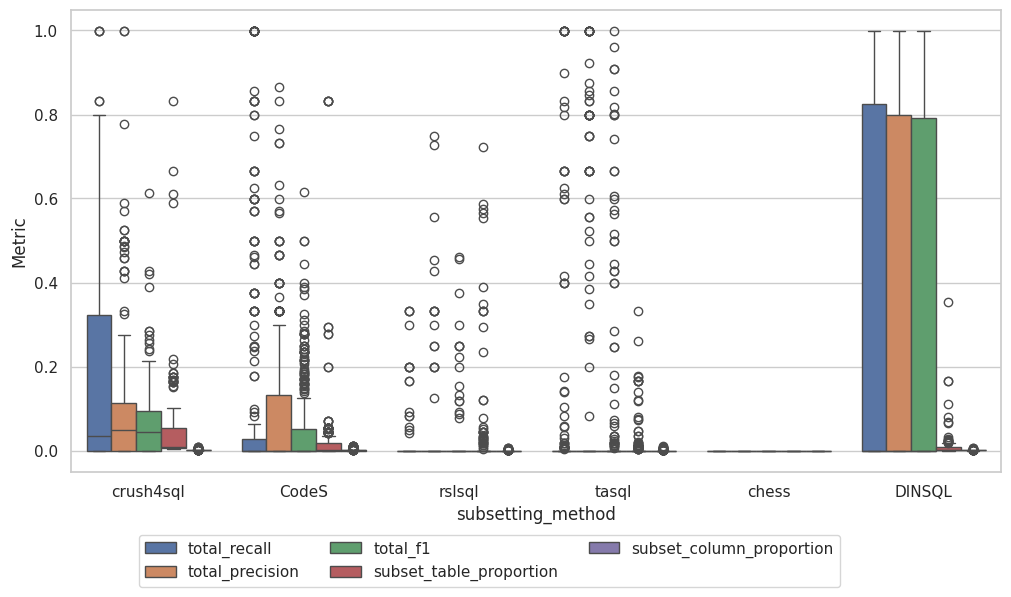

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=performance_df.melt(
        id_vars=["subsetting_method", "all_models_compatible"],
        value_vars=["total_recall", "total_precision", "total_f1", "subset_table_proportion", "subset_column_proportion"],
        value_name="Metric",
        var_name="Metric Name"
    ).query("Metric<=1.0 and ~all_models_compatible"),
    x="subsetting_method",
    y="Metric",
    hue="Metric Name"
)
plt.legend(bbox_to_anchor=(0.45, -0.25), loc='lower center', borderaxespad=0, ncols=3)

### Performance by Subsetting Method and Benchmark for All-Model-Compatible Schemas

<Figure size 1200x600 with 0 Axes>

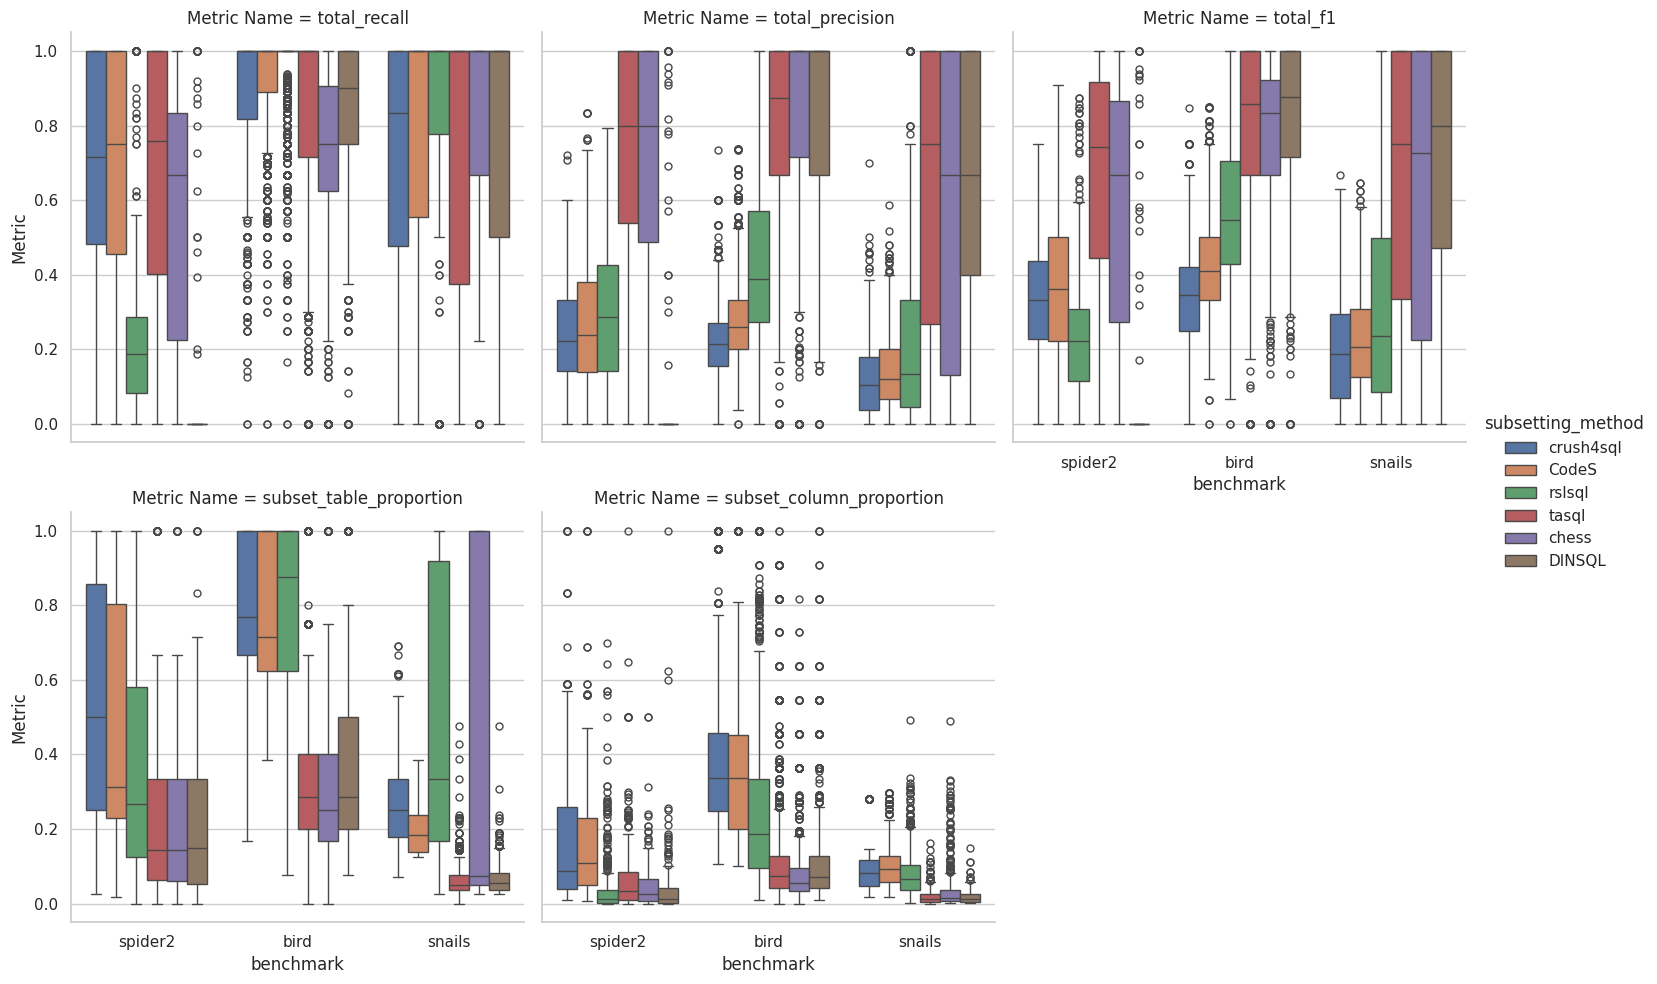

In [ ]:
plt.figure(figsize=(12, 6))
sns.catplot(
    data=performance_df.melt(
        id_vars=["subsetting_method", "all_models_compatible", "benchmark"],
        value_vars=["total_recall", "total_precision", "total_f1", "subset_table_proportion", "subset_column_proportion"],
        value_name="Metric",
        var_name="Metric Name"
    ).query("Metric<=1.0 and all_models_compatible"),
    x="benchmark",
    y="Metric",
    hue="subsetting_method",
    kind="box",
    col="Metric Name",
    col_wrap=3
)

### Inference Time by Subsetting Method

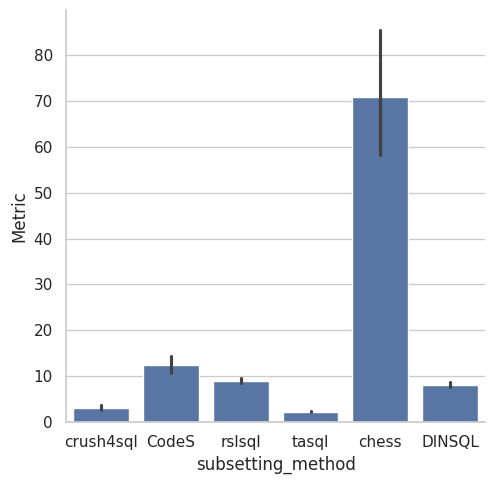

In [ ]:
g = sns.catplot(
    data=performance_df.melt(
        id_vars=["subsetting_method", "all_models_compatible", "benchmark"],
        value_vars=["inference_time"],
        value_name="Metric",
        var_name="Metric Name"
    ).query("Metric > 0"),
    kind="bar",
    x="subsetting_method",
    y="Metric"
)

### Prompt Tokens by Subsetting Method

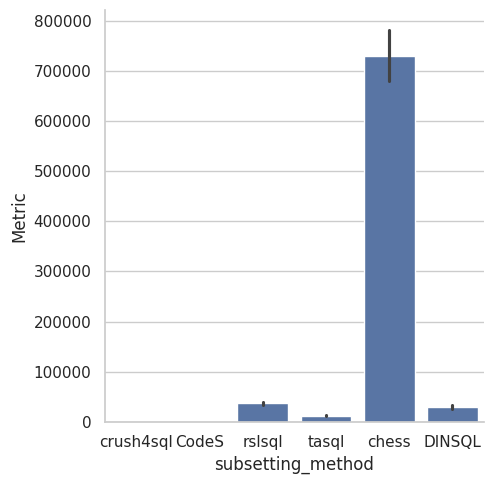

In [ ]:
g = sns.catplot(
    data=performance_df.melt(
        id_vars=["subsetting_method", "all_models_compatible", "benchmark"],
        value_vars=["prompt_tokens"],
        value_name="Metric",
        var_name="Metric Name"
    ).query("Metric >= 0"),
    kind="bar",
    x="subsetting_method",
    y="Metric"
)